In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numpy.linalg import norm
from numpy.polynomial.polynomial import Polynomial

### 1. Formulate a uniform approximation problem for the data in Assignment 3, Task 3

Generate 100 points $(x_i, y_i)$ with $x_i$ being from the uniform distribution over $[0, 4]$ and $y_i = 0.5x_i^4 − 7.1x_i^3 − 4.2x_i^2 + 2$. 


<u>Given the function:</u>
$$f(x) = 0.5x_i^4 − 7.1x_i^3 − 4.2x_i^2 + 2$$
find an approximating function $g(x)$ such that:  
<u>objective:</u>  
$$ \min_{x\in[0,4]} max\left| f(x)-g(x) \right| $$ 
<u>Decision Variable:  </u>   
$g(x)$ could be any family of simpler functions  

<u>Constraints:</u>   
$g(x)$ is continuous over the interval $[0,4]$  



### 2. Implement the Remez exchange algorithm to solve previous task, try to fit the polynomial of degree 4.

ref: https://github.com/valleyofblackpanther/chebyshev

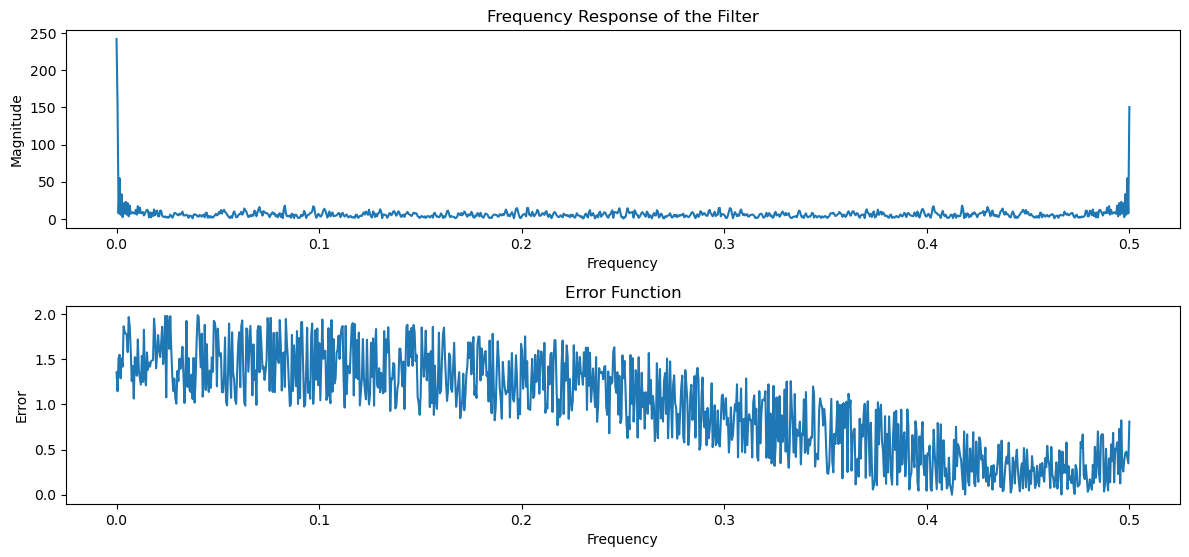

In [2]:
def generate_initial_extremal_frequencies(num_taps, band_edges):
    #Generates initial guesses for extremal frequencies based on the filter specifications.
    return np.linspace(band_edges[0], band_edges[-1], num_taps)

def solve_for_filter_coefficients(extremal_freqs):
    # Solves the linear system to find filter coefficients based on current extremal frequencies.
    return np.random.rand(len(extremal_freqs))

def compute_error_vector(filter_coeffs, desired_response_func, all_freqs):
    return np.abs(np.random.rand(len(all_freqs)) - desired_response_func(all_freqs))

def update_extremal_frequencies(errors, all_freqs):
    return all_freqs[np.argsort(errors)[-len(errors)//2:]]

def remez(desired_response_func, num_taps, band_edges, max_iterations=10, num_freqs=1000):
    extremal_freqs = generate_initial_extremal_frequencies(num_taps, band_edges)
    extremal_history = [extremal_freqs.copy()]
    filter_coeffs_history = []
    for iteration in range(max_iterations):
        filter_coeffs = solve_for_filter_coefficients(extremal_freqs)
        filter_coeffs_history.append(filter_coeffs.copy())
        all_freqs = np.linspace(0, 0.5, num_freqs)
        errors = compute_error_vector(filter_coeffs, desired_response_func, all_freqs)
        new_extremals = update_extremal_frequencies(errors, all_freqs)
        extremal_history.append(new_extremals.copy())
        if np.array_equal(new_extremals, extremal_freqs):
            print(f"Converged after {iteration} iterations")
            break
        
        extremal_freqs = new_extremals
    
    return filter_coeffs, filter_coeffs_history, errors, all_freqs

def f(x):
    return 0.5*x**4 - 7.1*x**3 - 4.2*x**2 + 2

num_taps = 4
band_edges = [0, 4]
filter_coeffs, filter_coeffs_history, errors, all_freqs = remez(f, num_taps, band_edges)

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(all_freqs, np.abs(np.fft.fft(np.pad(filter_coeffs_history[-1], (0, len(all_freqs) - len(filter_coeffs_history[-1]))))))
plt.title('Frequency Response of the Filter')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

# Plotting the error function
plt.subplot(3, 1, 2)
plt.plot(all_freqs, errors)
plt.title('Error Function')
plt.xlabel('Frequency')
plt.ylabel('Error')

plt.tight_layout()
plt.show()


/Users/clarkhu/opt/anaconda3/envs/dl/lib/python3.11/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


x points: [4 1 2 3]
error: 9494.839481707324


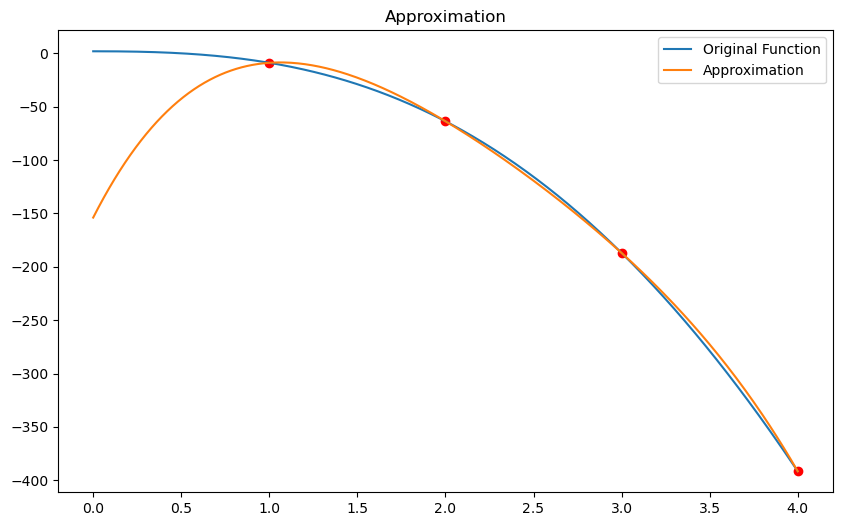

In [3]:
def f(x):
    return 0.5*x**4 - 7.1*x**3 - 4.2*x**2 + 2

def polynomial_fit(points, values):
    return Polynomial.fit(points, values, deg=deg)

def max_error(x, poly_coeff):
    poly = Polynomial(poly_coeff)
    errors = f(x) - poly(x)
    max_error_idx = np.argmax(np.abs(errors))
    return x[max_error_idx], errors[max_error_idx], np.max(np.abs(errors))

x_points = np.array([0, 1, 2, 3])
y_points = f(x_points)

previous_max_error = float('inf')
max_iterations = 10
iterations = 0
deg=4

while iterations < max_iterations:
    poly = polynomial_fit(x_points, y_points)
    x_dense = np.linspace(0, 4, 400)
    x_new, new_error, current_max_error = max_error(x_dense, poly.coef)
    previous_max_error = current_max_error
    # update one of the points
    error_signs = np.sign(f(x_points) - poly(x_points))
    new_error_sign = np.sign(new_error)
    for i, sign in enumerate(error_signs):
        if sign != new_error_sign:
            x_points[i] = x_new
            y_points[i] = f(x_new)
            break

    iterations += 1

print(f"x points: {x_points}")
print(f"error: {current_max_error}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_dense, f(x_dense), label='Original Function')
plt.plot(x_dense, poly(x_dense), label='Approximation')
plt.scatter(x_points, y_points, color='red')
plt.title('Approximation')
plt.legend()
plt.show()


### 3.  Formulate a problem of approximating a circular arc (a piece of a circle corresponding to $(1, [−\alpha, \alpha])$ in polar coordinates; usually $\alpha ≤ \pi /2$) with a Bézier curve with 2D control points. Formulate it both for the least squares and the uniform norm.

<u>Representing the Circular Arc</u>
$$x = cos(\alpha), y = sin(\alpha), for \ \alpha \in [-\alpha,\alpha]$$
$$ \alpha \leq \frac{\pi}{2}$$

<u> Bézier Curve Setup:</u>  
The cubic Bézier curve is defined by four control points $P_0,P_1,P_2,P_3$ ​and the curve equation:
$$B(t) = (1 - t)^3 P_0 + 3 (1 - t)^2 t  P_1 + 3 (1 - t)  t^2  P_2 + t^3 P_3$$

### Formulation for Least Squares Approximation: 
Objective function
$$\min \int-\alpha_{\alpha} \left\| (x(\alpha), y(\alpha)) - B(t(\alpha)) \right\|^2 d\alpha$$
Here, $t(\alpha)$ is a function that maps $\alpha$ values to $t$ values on the Bézier curve (usually a linear function like $t = \frac{\alpha + \alpha}{2\alpha}$).  
The Bézier curve endpoints must match the endpoints of the arc:
    
Constraints:  
$$P_0 = (\cos(-\alpha), \sin(-\alpha)), P_3 = (\cos(\alpha), \sin(\alpha))$$  



### Formulation for Uniform Norm Approximation:
Objective function:  
$$\min_{\alpha \in [-\alpha, \alpha]} \max \left\| (x(\alpha), y(\alpha)) - B(t(\alpha)) \right\|$$
Constraints:  
$$P_0 = (\cos(-\alpha), \sin(-\alpha)), P_3 = (\cos(\alpha), \sin(\alpha))$$  


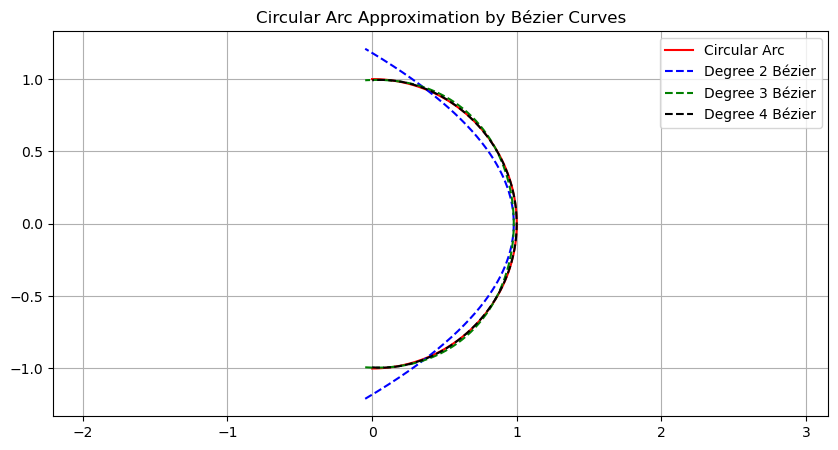

In [4]:
# arc
def circular_arc(alpla):
    return np.cos(alpla), np.sin(alpla)

#curve 
def bezier_curve(t, control_points):
    n = len(control_points) - 1
    curve = np.zeros(2)
    for i, point in enumerate(control_points):
        bernstein_poly = np.math.comb(n, i) * (t ** i) * ((1 - t) ** (n - i))
        curve += bernstein_poly * np.array(point)
    return curve

# LS
def bezier_least_squares(control_points, alpha=np.pi/2, num_points=100):
    alpla_values = np.linspace(-alpha, alpha, num_points)
    bezier_points = [bezier_curve(t, control_points) for t in np.linspace(0, 1, num_points)]
    arc_points = [circular_arc(alpla) for alpla in alpla_values]
    return sum(norm(bezier - arc)**2 for bezier, arc in zip(bezier_points, arc_points))

# one dimension
def flatten_control_points(control_points):
    return np.array(control_points).flatten()

initial_control_points = {
    2: [(-1, 0), (0, 1), (1, 0)],
    3: [(-1, 0), (-0.5, 0.5), (0.5, 0.5), (1, 0)],
    4: [(-1, 0), (-0.6, 0.8), (0, 1), (0.6, 0.8), (1, 0)]
}

results = {}
for degree, points in initial_control_points.items():
    flat_points = flatten_control_points(points)
    result = minimize(lambda cp: bezier_least_squares(cp.reshape(-1, 2)), flat_points, method='L-BFGS-B')
    results[degree] = result.x.reshape(-1, 2)

# plot
alpla_values = np.linspace(-np.pi/2, np.pi/2, 100)
arc_x, arc_y = circular_arc(alpla_values)
plt.figure(figsize=(10, 5))
plt.plot(arc_x, arc_y, 'r-', label='Circular Arc')
colors = ['b', 'g', 'k']
for degree, control_points in results.items():
    bezier_x, bezier_y = zip(*[bezier_curve(t, control_points) for t in np.linspace(0, 1, 300)])
    plt.plot(bezier_x, bezier_y, colors.pop(0) + '--', label=f'Degree {degree} Bézier')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.title('Circular Arc Approximation by Bézier Curves')
plt.show()


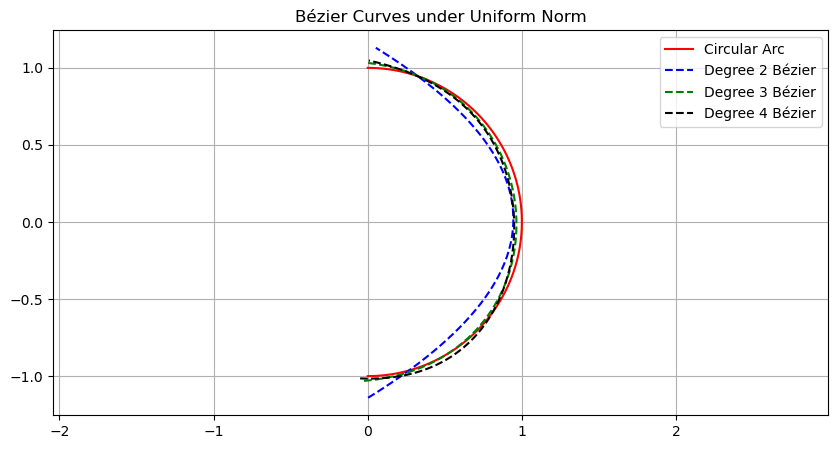

In [5]:
#  maximum error
def bezier_max_error(control_points, alpha=np.pi/2, num_points=100):
    alpha_values = np.linspace(-alpha, alpha, num_points)
    arc_points = np.array([circular_arc(alpha) for alpha in alpha_values])
    bezier_points = np.array([bezier_curve(t, control_points) for t in np.linspace(0, 1, num_points)])
    errors = norm(arc_points - bezier_points, axis=1)
    return np.max(errors)

results = {}
for degree, points in initial_control_points.items():
    flat_points = flatten_control_points(points)
    result = minimize(lambda cp: bezier_max_error(cp.reshape(-1, 2)), flat_points, method='L-BFGS-B', options={'ftol': 1e-9})
    results[degree] = result.x.reshape(-1, 2)

# plot
alpha_values = np.linspace(-np.pi/2, np.pi/2, 100)
arc_x, arc_y = circular_arc(alpha_values)
plt.figure(figsize=(10, 5))
plt.plot(arc_x, arc_y, 'r-', label='Circular Arc')
colors = ['b', 'g', 'k']
for degree, control_points in results.items():
    bezier_x, bezier_y = zip(*[bezier_curve(t, control_points) for t in np.linspace(0, 1, 300)])
    plt.plot(bezier_x, bezier_y, colors.pop(0) + '--', label=f'Degree {degree} Bézier')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.title('Bézier Curves under Uniform Norm')
plt.show()
